# Cape Town Air BNB Prices #

## 1. Import Libraries and Read in Data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 300)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')  

import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
from geopy.distance import great_circle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot


/Users/dolcikey/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import warnings

In [3]:
# Read in data 

listing_df = pd.read_csv('listings.csv')

In [4]:
# Read in crime statistics data to compliment neighbourhoods

crime_df = pd.read_csv('SA_crime_ward.csv')

In [5]:
#drop the nan row (was originally a double of column names not values)

crime_df.drop(111, inplace = True)

In [6]:
crime_df['geo_code'].astype(int)

0        1
1        2
2        3
3        4
4        5
      ... 
106    107
107    108
108    109
109    110
110    111
Name: geo_code, Length: 111, dtype: int64

## 2. Clean the data. 

In [7]:
# Dealing with NAs starting with Listing DataFrame


#Limit data set to under 3000 a night 
#change these reviews to 0 

listing_df.isna().sum()

id                                    0
name                                  0
host_id                               0
host_name                             3
neighbourhood_group               24079
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                        6823
reviews_per_month                  6823
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [8]:
# Because the data set is over 24k, I decided to drop the nan values of reviews and last review (the same rows were nan for each)
# In researching SA Cape Town Air BNB, I found that houses with no reviews tended to have been expensive, but never booked
# Dropping these values, I expect to increase accuracy as some houses with massive price tags have never been booked or reviewed

listing_df['number_of_reviews'] = listing_df['number_of_reviews'].replace(np.nan, 0)

In [9]:
listing_df['last_review'] = listing_df['last_review'].replace(np.nan, 0)

In [10]:
# No values in this column at all, drop column

listing_df = listing_df[listing_df.columns.drop('neighbourhood_group')]

In [11]:
# Seemingly half of the rates were in ZAR and half in dollars (lower cost was in USD)
# Air BNB zar conversion rate is 14.3 (current rate is 16.5)
# The most expensive house I could find was 3,000 that had been reviewed once/had been booked

listing_df['price_usd'] = listing_df.price.apply(lambda x: x/14.23 if x>= 3000 else x)

In [12]:
# Testing for listings with price = 0
# Closed listing does not exist 9775 is 20685098 and it is listed as price = 0 

listing_df[listing_df.price == 0.0]

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_usd
9775,20685098,"The Deep Glen Room, Camps Bay",2103032,Carlos,Ward 54,-33.94719,18.38351,Private room,0,2,49,2020-03-16,1.54,3,90,0.0
9808,20736711,Family home with pool (Min 7 day booking),49400083,Norma,Ward 71,-34.06573,18.43813,Entire home/apt,0,5,2,2020-01-02,0.07,1,31,0.0


In [13]:
listing_df.drop(9775, inplace = True)

In [14]:
#listing append 9808 is 20736711 price was 0.0 is actually 121 USD, minimum night 7

listing_df.at[9808, 'price_usd'] = 121
listing_df.at[9808, 'minimum_nights'] = 7

In [17]:
#minimum nights is 1125, which while this is true on airbnb, this place has not been booked at this minimum night and I believe it would scew the data. 

listing_df.drop(4957, inplace = True)

In [18]:
# Splitting by room type by making dummy binomial variables

listing_df = pd.get_dummies(listing_df, columns=['room_type'])

In [19]:
# Neighbourhoods

listing_df.neighbourhood = listing_df.neighbourhood.map(lambda x: x.replace('Ward', ''))

In [20]:
listing_df.neighbourhood = listing_df.neighbourhood.astype(int)

In [21]:
# Merge df on geo code/neighbourhood for the crime stats to get the total crime per 10,000 tied to each listing
# My thought process was that there may be a significant difference in price between somewhere with higher crime and lower crime rates


listing_df = listing_df.merge(crime_df, left_on='neighbourhood', right_on = 'geo_code' ,how='left')


## 3. Feature Engineering 

In [22]:
# Ward 112 impute mean crime from surounding wards (Ward 103, Ward 21, Ward 70 = 175)

In [23]:
listing_df['total_10000 _rounded'] = np.where((listing_df['neighbourhood'] == 112), 175, listing_df['total_10000 _rounded'])

In [24]:
# Ward 113  impute mean crime from surounding wards (Ward 107, Ward 1, Ward 4 = 237)

In [25]:
listing_df['total_10000 _rounded'] = np.where((listing_df['neighbourhood'] == 113), 237, listing_df['total_10000 _rounded'])

In [26]:
# Ward 115  impute mean crime from surounding wards (Ward 54, Ward 57, Ward 77, Ward 55 = 266)

In [27]:
listing_df['total_10000 _rounded'] = np.where((listing_df['neighbourhood'] == 115), 266, listing_df['total_10000 _rounded'])

In [28]:
# Ward 116  impute mean crime from surounding wards (Ward 87, Ward 18, Ward 35, Ward 76, Ward 92, Ward 79, Ward 78 = 265)

In [29]:
listing_df['total_10000 _rounded'] = np.where((listing_df['neighbourhood'] == 116), 265, listing_df['total_10000 _rounded'])

In [30]:
# Price Log 

listing_df['price_usd_log'] = np.log(listing_df['price_usd'])

In [31]:
listing_df['price_usd'].describe()

count    24077.000000
mean      1041.737721
std        792.416931
min        119.000000
25%        505.000000
50%        846.000000
75%       1393.000000
max      21082.782853
Name: price_usd, dtype: float64

In [32]:
# Feature Engineering

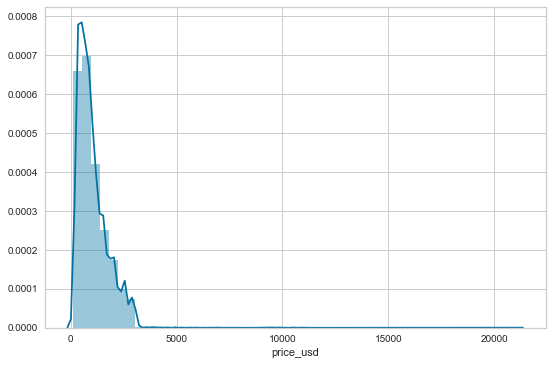

In [33]:
sns.distplot(listing_df['price_usd']);

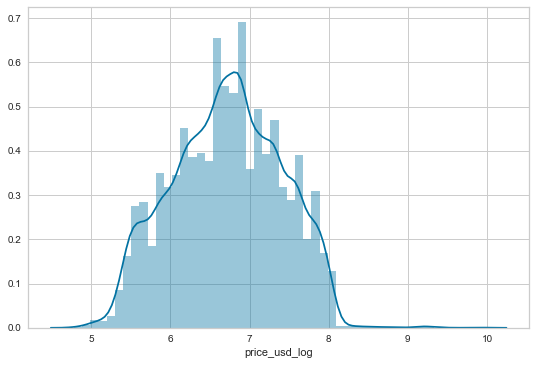

In [34]:
# Using the log I can normalize the plot a little bit 

sns.distplot(listing_df['price_usd_log'])

In [35]:
# Distance to Cape Town City Center

city_center = (-33.9249,18.4241)
listing_df['distance_cc'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(city_center, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)
# Distance VA Waterfront 

va_water = (-33.9036, 18.4205)
listing_df['distance_waterfront'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(va_water, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)

# Stellenbosch 

wine_lands = (-34.075691, 18.843266)
listing_df['distance_wine'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(wine_lands, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)

# Distance from Airport

airport = (-33.9249,18.4241)
listing_df['distance_airport'] = listing_df[['latitude', 'longitude']].apply(lambda x: great_circle(airport, 
                                                                                               (x['latitude'], x['longitude'])).miles, axis = 1)


## 4. Statistical Testing

In [36]:
#Statistical Testing

In [37]:
# minimum nights > 4
# min nights < 4 
# mean min_nights is 3.93
# Prices of Air BNBs with less than 4 minimum nights is statistically different than houses with minimum nights greater or equal to 4. 
#2 sample ttest

stats.ttest_ind(listing_df[listing_df['minimum_nights'] >= 4]['price_usd_log'], listing_df[listing_df['minimum_nights'] < 4]['price_usd_log']) 



Ttest_indResult(statistic=1.4755604157332152, pvalue=0.14007501596877572)

In [38]:
# As we get closer the the City Center, the mean of the price changes. 
# ANOVA
# Combine testing needed


x = listing_df[listing_df['distance_cc'] >= 10]['price_usd_log']
y = listing_df[listing_df['distance_cc'] < 10]['price_usd_log']
ten_miles = stats.f_oneway(x, y)

x = listing_df[listing_df['distance_cc'] >= 8]['price_usd_log']
y = listing_df[listing_df['distance_cc'] < 8]['price_usd_log']
eight_miles = stats.f_oneway(x, y)

x = listing_df[listing_df['distance_cc'] >= 1]['price_usd_log']
y = listing_df[listing_df['distance_cc'] < 1]['price_usd_log']
one_mile = stats.f_oneway(x, y)

print('10 miles: ', ten_miles)
print('8 miles: ', eight_miles)
print('1 mile: ', one_mile)

10 miles:  F_onewayResult(statistic=1.6520841662085215, pvalue=0.19868786638429162)
8 miles:  F_onewayResult(statistic=8.09296308368143, pvalue=0.0044474931650501206)
1 mile:  F_onewayResult(statistic=76.63478948952003, pvalue=2.1893563247339145e-18)


In [39]:
# Independent T Test we can also see that the distance_cc is statistically different when looked over a mile to city center

ttest_distance_cc = stats.ttest_ind(listing_df[listing_df['distance_cc'] < 1]['price_usd_log'], listing_df[listing_df['distance_cc'] >=1]['price_usd_log']) 
ttest_distance_cc

Ttest_indResult(statistic=8.75412985336181, pvalue=2.1893563247603548e-18)

In [40]:
# H0 Price is not statistically contingent on the level of crime per 10,000
# H1 Price is statistically different based on the level of crime per 10,000

stats.ttest_ind(listing_df[listing_df['total_10000 _rounded'] >= 235.17]['price_usd'], listing_df[listing_df['total_10000 _rounded'] <235.17]['price_usd'])

# This one really shocked me. I thought for sure there would be a statistical different between the cost of the airbnb in areas with less crime per 10,000
# Failed to reject Null Hypothesis

Ttest_indResult(statistic=-2.1251833612596194, pvalue=0.033581471142552013)

In [41]:
# When price_usd_log is used, there is some statistical significance 

stats.ttest_ind(listing_df[listing_df['total_10000 _rounded'] >= 235.17]['price_usd_log'], listing_df[listing_df['total_10000 _rounded'] <235.17]['price_usd_log'])

Ttest_indResult(statistic=1.7483061938957232, pvalue=0.08042376806697754)

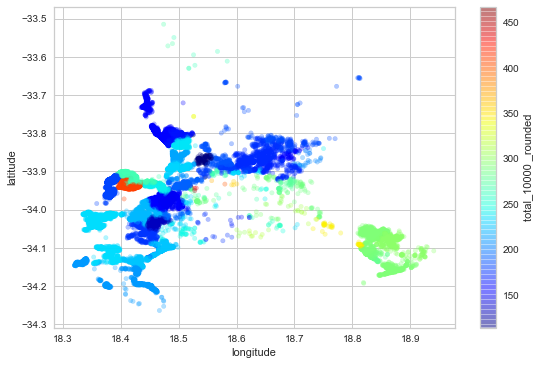

In [42]:
# This graphic is interesting as it shows that the air bnbs only have small pockets where the crime rate is over 250-300 per 10,000 
# This may be why there is not enough data to go on, as places with high crime seem to have a very low amount of air bnb housing

listing_df.plot(kind= 'scatter', x = 'longitude', y = 'latitude', alpha = .3, c = 'total_10000 _rounded', cmap = plt.get_cmap('jet'));

In [43]:
#geopandas data?

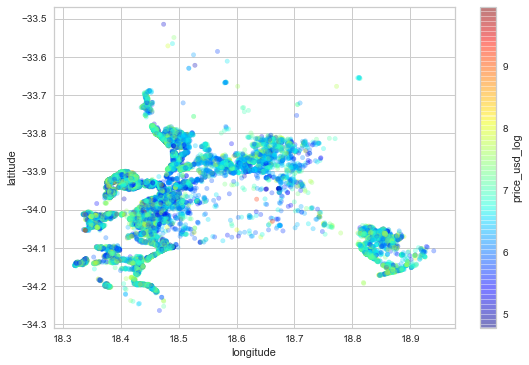

In [44]:
# From this visualization we can see that it looks like the more expensive places are along the coast line when referenced with a map of Cape Town
# The middle area with scarce 
listing_df.plot(kind= 'scatter', x = 'longitude', y = 'latitude', alpha = .3, c = 'price_usd_log', cmap = plt.get_cmap('jet'));

## 5. Baseline model

In [46]:
# Baseline model; rmse:  669.5434143725225 r2:  0.0 using mean

subset = ['neighbourhood', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
x = listing_df[subset]
y = listing_df['price_usd_log']

dummy_regr = DummyRegressor(strategy = "mean")
dummy_regr.fit(x, y)
#DummyRegressor()
y_predict = dummy_regr.predict(y)
R2 = dummy_regr.score(x, y)

rmse = np.sqrt(metrics.mean_squared_error(y, y_predict))

print('rmse: ', rmse, 'r2: ', R2)

rmse:  0.6850296290742379 r2:  0.0


In [47]:
# Baseline model; rmse:  693.2896480095063 r2:  -0.07219047711717841 using median

subset = ['neighbourhood', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
x = listing_df[subset]
y = listing_df['price_usd_log']

dummy_regr = DummyRegressor(strategy = "median")
dummy_regr.fit(x, y)
#DummyRegressor()
y_predict = dummy_regr.predict(y)
R2 = dummy_regr.score(x, y)

rmse = np.sqrt(metrics.mean_squared_error(y, y_predict))

print('rmse: ', rmse, 'r2: ', R2)

rmse:  0.6853787024523643 r2:  -0.0010194079283252222


## 6. Test for Multi-Colinearity  

## 7. Model Testing